## Intra-channel fiber nonlinearity compensation with the first-order perturbation nonlinear interference model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from optic.comm.modulation import grayMapping, detector
from optic.comm.metrics import fastBERcalc, calcEVM
from optic.models.perturbation import perturbationNLIN
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.dsp.core import pnorm, firFilter, pulseShape, delaySignal
from optic.plot import pconst
from optic.utils import dB2lin, dBm2W, parameters, ber2Qfactor
from optic.models.tx import simpleWDMTx
import time

import logging as logg
logg.basicConfig(level=logg.WARN, format='%(message)s', force=True)

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
        from optic.models.modelsGPU import manakovSSF
    else:
        from optic.dsp.core import firFilter
        from optic.models.channels import manakovSSF
except ImportError:
    from optic.dsp.core import firFilter
    from optic.models.channels import manakovSSF

c:\Users\edson.DESKTOP-54IJM4F\anaconda3\envs\opticommpy-env\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


### Generate single carrier transmission signal

In [20]:
# Run simulation 

# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 64           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 4            # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 4096       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 0        # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 0*100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

# generate WDM signal
sigWDM_Tx, symbTx, paramTx = simpleWDMTx(paramTx)
symbTx = symbTx[:,:,0]

# manually adjust the delay of the signal to facilitate the decimation at the receiver
sigWDM_Tx[:,0] = delaySignal(sigWDM_Tx[:,0], -0.25*1/paramTx.Rs, paramTx.Rs*paramTx.SpS)
sigWDM_Tx[:,1] = delaySignal(sigWDM_Tx[:,1], -0.25*1/paramTx.Rs, paramTx.Rs*paramTx.SpS)

  0%|          | 0/1 [00:00<?, ?it/s]

### Run performance vs fiber input power analysis

In [21]:
plotConstellations = False # set to True to plot constellations after each step
launchPower = np.arange(-4, 3.5, 0.5)
BERedc = np.zeros(len(launchPower))
BERnlc = np.zeros(len(launchPower))
BERnlcIdeal = np.zeros(len(launchPower))
SNRedc = np.zeros(len(launchPower))
SNRnlc = np.zeros(len(launchPower))
SNRnlcIdeal = np.zeros(len(launchPower))

for indPower, Pin in enumerate(launchPower):
    print('----------------------------')
    print(f'Fiber launch power: {Pin} dBm')
    # optical channel parameters
    paramCh = parameters()
    paramCh.Ltotal = 1600     # total link distance [km]
    paramCh.Lspan  = 80      # span length [km]
    paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
    paramCh.D = 17           # fiber dispersion parameter [ps/nm/km]
    paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
    paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
    paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
    paramCh.maxIter = 5      # maximum number of convergence iterations per step
    paramCh.tol = 1e-5       # error tolerance per step
    paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
    paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
    paramCh.prgsBar = False   # show progress bar
    #paramCh.saveSpanN = [1, 5, 9, 14]
    paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

    # nonlinear signal propagation with split-step Fourier
    sigWDM = manakovSSF(dB2lin(Pin)*sigWDM_Tx, paramCh)

    # matched filtering
    mf = pulseShape('rrc', paramTx.SpS, paramTx.Ntaps, paramTx.alphaRRC)
    sigRx = firFilter(mf, sigWDM)  # pulse shaping filter

    # dispersion compensation
    paramEDC = parameters()
    paramEDC.L = paramCh.Ltotal
    paramEDC.D = paramCh.D
    paramEDC.Fc = paramTx.Fc
    paramEDC.Rs = paramTx.Rs
    paramEDC.Fs = paramCh.Fs

    sigEDC = edc(sigRx, paramEDC)
    rot = np.mean(sigWDM_Tx[sigEDC!=0]/sigEDC[sigEDC!=0])    
    sigEDC = np.roll(sigEDC, -1, axis=0)  # roll to remove the first sample
        
    # adaptive equalization parameters
    paramEq = parameters()
    paramEq.nTaps = 15
    paramEq.SpS = 2
    paramEq.numIter = 2
    paramEq.storeCoeff = False
    paramEq.M = paramTx.M
    paramEq.L = [int(0.2*symbTx.shape[0]), int(0.8*symbTx.shape[0])]
    paramEq.prgsBar = False
    paramEq.alg = ['nlms','dd-lms'] # M-QAM
    paramEq.mu = [1e-3, 1e-4] 
        
    sigEQ = mimoAdaptEqualizer(pnorm(sigEDC[0::paramTx.SpS//2]), paramEq, symbTx)
    
    # Carrier phase recovery parameters
    paramCPR = parameters()
    paramCPR.alg = 'bps'
    paramCPR.M   = paramTx.M
    paramCPR.N   = 95
    paramCPR.B   = 32
    
    # Perturbation-based NLIN calculation parameters
    paramNLIN = parameters()
    paramNLIN.mode = 'AMR'
    paramNLIN.Pin = paramTx.Pch_dBm + Pin
    paramNLIN.coeffTol = -30
    paramNLIN.lspan = paramCh.Lspan
    paramNLIN.length = paramCh.Ltotal
    paramNLIN.alpha = paramCh.alpha
    paramNLIN.D = paramCh.D
    paramNLIN.matrixOrder = 75
    paramNLIN.prec = np.complex64

    A = np.sqrt(dBm2W(paramNLIN.Pin)/2)

    # Calculate the perturbation-based NLIN    
    symbRx = pnorm(sigEQ.copy())     
    rot = np.mean(symbTx[symbRx!=0] / symbRx[symbRx!=0])
    symbRx = rot*symbRx
    symbTx_hat = symbTx.copy()
    constSymb = pnorm(grayMapping(paramTx.M, 'qam'))

    # hard decision detection
    symbTx_hat[:,0],_ = detector(pnorm(symbRx[:,0]), 0.5, constSymb, rule='ML')
    symbTx_hat[:,1],_ = detector(pnorm(symbRx[:,1]), 0.5, constSymb, rule='ML')
    
    # perturbation calculation
    start = time.time()
    nlin = perturbationNLIN(pnorm(symbTx_hat), paramNLIN)
    nlinIdeal = perturbationNLIN(pnorm(symbTx), paramNLIN)
    end = time.time()
    delay = end - start
    print(f'Time to run the perturbation model: {delay/2:.4f} s')

    symbPert = A*pnorm(symbTx_hat) + nlin
    rot = np.mean(symbTx[symbRx!=0] / pnorm(symbPert[symbRx!=0]))
    symbPert = rot*symbPert

    symbPertIdeal = A*pnorm(symbTx) + nlinIdeal
    rot = np.mean(symbTx[symbRx!=0] / pnorm(symbPertIdeal[symbRx!=0]))
    symbPertIdeal = rot*symbPertIdeal
    
    deltaNLIN = pnorm(symbPert)-pnorm(symbTx_hat) # estimate the symbol distortions due to NLIN
    deltaNLINIdeal = pnorm(symbPertIdeal)-pnorm(symbTx) # ideal estimate of the symbol distortions due to NLIN

    # Compensation of intra-channel NLIN with the perturbation model
    ntrials = 10
    EVM = np.zeros((ntrials, ntrials))
    phases = np.linspace(0, 2*np.pi, ntrials)
    amps = np.linspace(0.1, 4.1, ntrials)        
    discard = 20000
    
    for ind1, phi in enumerate(phases): 
        for ind2, amp in enumerate(amps):       
            symbRxNLC = symbRx - amp*deltaNLIN*np.exp(1j*phi)                  
            EVM[ind1, ind2] = 100*calcEVM(pnorm(symbRxNLC[discard:-discard,:]), 16, 'qam', symbTx[discard:-discard,:])[0]

    indx = np.unravel_index(np.argmin(EVM, axis=None), EVM.shape)     
    print(f'Minimum EVM: {EVM[indx[0],indx[1]]:.2f} at phase {phases[indx[0]]:.2f} rad, amplitude {amps[indx[1]]:.2f}')
    
    # Calculate performance metrics with ideal estimation and NLIN compensation
    symbRxNLCIdeal = symbRx - amps[indx[1]]*deltaNLINIdeal*np.exp(1j*phases[indx[0]])   
    #symbRxNLCIdeal = cpr(symbRxNLCIdeal, paramCPR)    
    BER, _, SNR = fastBERcalc(pnorm(symbRxNLCIdeal[discard:-discard,:]), pnorm(symbTx[discard:-discard,:]), paramTx.M, 'qam')
    BERnlcIdeal[indPower] = np.mean(BER)
    SNRnlcIdeal[indPower] = np.mean(SNR)

    # Calculate performance metrics with NLIN compensation
    symbRxNLC = symbRx - amps[indx[1]]*deltaNLIN*np.exp(1j*phases[indx[0]])   
    #symbRxNLC = cpr(symbRxNLC, paramCPR)    
    BER, _, SNR = fastBERcalc(pnorm(symbRxNLC[discard:-discard,:]), pnorm(symbTx[discard:-discard,:]), paramTx.M, 'qam')
    BERnlc[indPower] = np.mean(BER)
    SNRnlc[indPower] = np.mean(SNR)
    
    # Calculate performance metrics without NLIN compensation
    #symbRxEDC = cpr(symbRx, paramCPR)
    symbRxEDC = symbRx.copy()
    BER, _, SNR = fastBERcalc(pnorm(symbRxEDC[discard:-discard,:]), pnorm(symbTx[discard:-discard,:]), paramTx.M, 'qam')
    BERedc[indPower] = np.mean(BER)
    SNRedc[indPower] = np.mean(SNR)   

    print(f'After EDC: BER = {BERedc[indPower]:.2e}, SNR = {SNRedc[indPower]:.2f} dB')
    if plotConstellations:
        pconst(symbRxEDC[discard:-discard,:], pType='fancy')    
    print(f'After NLC: BER = {BERnlc[indPower]:.2e}, SNR = {SNRnlc[indPower]:.2f} dB')
    if plotConstellations:
        pconst(symbRxNLC[discard:-discard,:], pType='fancy')
    print(f'After ideal NLC: BER = {BERnlcIdeal[indPower]:.2e}, SNR = {SNRnlcIdeal[indPower]:.2f} dB')
    if plotConstellations:
        pconst(symbRxNLCIdeal[discard:-discard,:], pType='fancy')
 

----------------------------
Fiber launch power: -4.0 dBm
Time to run the perturbation model: 3.6427 s
Minimum EVM: 5.74 at phase 5.59 rad, amplitude 0.99
After EDC: BER = 1.12e-01, SNR = 12.39 dB
After NLC: BER = 1.12e-01, SNR = 12.39 dB
After ideal NLC: BER = 1.12e-01, SNR = 12.37 dB
----------------------------
Fiber launch power: -3.5 dBm
Time to run the perturbation model: 3.6175 s
Minimum EVM: 4.59 at phase 5.59 rad, amplitude 0.54
After EDC: BER = 9.47e-02, SNR = 13.34 dB
After NLC: BER = 9.47e-02, SNR = 13.35 dB
After ideal NLC: BER = 9.47e-02, SNR = 13.34 dB
----------------------------
Fiber launch power: -3.0 dBm
Time to run the perturbation model: 3.5904 s
Minimum EVM: 3.66 at phase 0.00 rad, amplitude 0.54
After EDC: BER = 7.79e-02, SNR = 14.32 dB
After NLC: BER = 7.73e-02, SNR = 14.34 dB
After ideal NLC: BER = 7.71e-02, SNR = 14.35 dB
----------------------------
Fiber launch power: -2.5 dBm
Time to run the perturbation model: 3.6204 s
Minimum EVM: 2.96 at phase 0.00 rad,

### Plot results

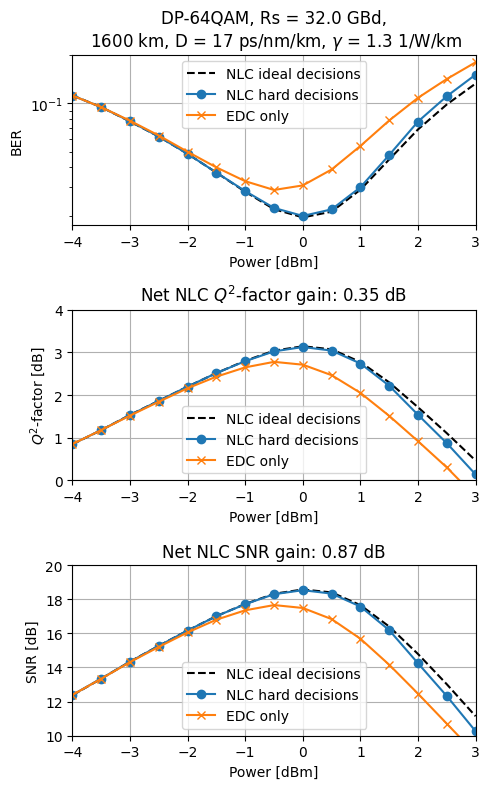

In [45]:
plt.figure(figsize=(5, 8))
plt.subplot(3,1,1)
plt.title(f'DP-{paramTx.M}QAM, Rs = {paramTx.Rs/1e9:.1f} GBd,\n {paramCh.Ltotal} km, D = {paramCh.D} ps/nm/km, $\gamma$ = {paramCh.gamma} 1/W/km')
plt.plot(launchPower, BERnlcIdeal,'k--', label='NLC ideal decisions')
plt.plot(launchPower, BERnlc, marker='o', label='NLC hard decisions')
plt.plot(launchPower, BERedc, marker='x', label='EDC only')
plt.yscale('log')
plt.xlabel('Power [dBm]')
plt.ylabel('BER')
plt.xlim(-4, 3)
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.plot(launchPower, ber2Qfactor(BERnlcIdeal), 'k--', label='NLC ideal decisions')
plt.plot(launchPower, ber2Qfactor(BERnlc), marker='o', label='NLC hard decisions')
plt.plot(launchPower, ber2Qfactor(BERedc), marker='x', label='EDC only')
plt.title(f'Net NLC $Q^2$-factor gain: { np.max(ber2Qfactor(BERnlc))-np.max(ber2Qfactor(BERedc)):.2f} dB')
plt.xlabel('Power [dBm]')
plt.ylabel('$Q^2$-factor [dB]')
plt.ylim(0, 4)
plt.xlim(-4, 3)
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.plot(launchPower, SNRnlcIdeal, 'k--', label='NLC ideal decisions')
plt.plot(launchPower, SNRnlc, marker='o', label='NLC hard decisions')  
plt.plot(launchPower, SNRedc, marker='x', label='EDC only')
plt.ylim(10, 20)
plt.xlim(-4, 3)
plt.title(f'Net NLC SNR gain: {np.max(SNRnlc)-np.max(SNRedc):.2f} dB')
plt.xlabel('Power [dBm]')
plt.ylabel('SNR [dB]') 
plt.grid(True)
plt.legend()
plt.tight_layout()